In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + \
    seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))

    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 6s 48ms/step - loss: 73.2144 - mae: 73.7136
Epoch 2/100
8/8 [==============================] - 0s 42ms/step - loss: 71.8829 - mae: 72.3820
Epoch 3/100
8/8 [==============================] - 0s 41ms/step - loss: 71.1747 - mae: 71.6739
Epoch 4/100
8/8 [==============================] - 0s 48ms/step - loss: 69.8038 - mae: 70.3031
Epoch 5/100
8/8 [==============================] - 0s 45ms/step - loss: 69.3436 - mae: 69.8427
Epoch 6/100
8/8 [==============================] - 0s 46ms/step - loss: 66.7656 - mae: 67.2644
Epoch 7/100
8/8 [==============================] - 0s 43ms/step - loss: 64.1345 - mae: 64.6338
Epoch 8/100
8/8 [==============================] - 0s 42ms/step - loss: 62.0535 - mae: 62.5524
Epoch 9/100
8/8 [==============================] - 0s 47ms/step - loss: 59.5496 - mae: 60.0484
Epoch 10/100
8/8 [==============================] - 0s 35ms/step - loss: 56.8676 - mae: 57.3663
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 33ms/step - loss: 25.4121 - mae: 25.9092
Epoch 88/100
8/8 [==============================] - 0s 33ms/step - loss: 17.7013 - mae: 18.1970
Epoch 89/100
8/8 [==============================] - 0s 34ms/step - loss: 17.9040 - mae: 18.3992
Epoch 90/100
8/8 [==============================] - 0s 34ms/step - loss: 16.9302 - mae: 17.4237
Epoch 91/100
8/8 [==============================] - 0s 35ms/step - loss: 21.1682 - mae: 21.6637
Epoch 92/100
8/8 [==============================] - 0s 40ms/step - loss: 12.0945 - mae: 12.5859
Epoch 93/100
8/8 [==============================] - 0s 38ms/step - loss: 12.6077 - mae: 13.0984
Epoch 94/100
8/8 [==============================] - 0s 39ms/step - loss: 21.4067 - mae: 21.9033
Epoch 95/100
8/8 [==============================] - 0s 44ms/step - loss: 16.9230 - mae: 17.4187
Epoch 96/100
8/8 [==============================] - 0s 40ms/step - loss: 15.8586 - mae: 16.3534
Epoch 97/100
8/8 [==============================] - 0

(1e-08, 0.0001, 0.0, 30.0)

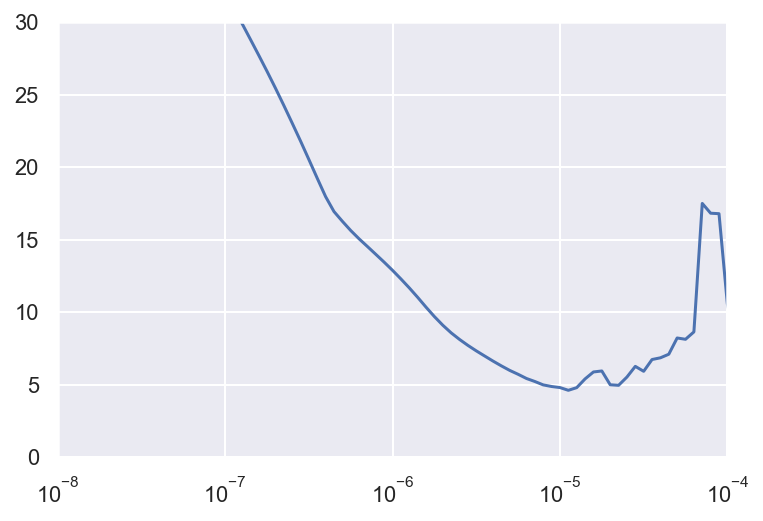

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 4s 27ms/step - loss: 33.5999 - mae: 34.0956
Epoch 2/500
31/31 [==============================] - 1s 25ms/step - loss: 8.4929 - mae: 8.9781
Epoch 3/500
31/31 [==============================] - 1s 27ms/step - loss: 6.9030 - mae: 7.3851
Epoch 4/500
31/31 [==============================] - 1s 20ms/step - loss: 6.3056 - mae: 6.7856
Epoch 5/500
31/31 [==============================] - 1s 18ms/step - loss: 5.7222 - mae: 6.2020
Epoch 6/500
31/31 [==============================] - 1s 25ms/step - loss: 5.7100 - mae: 6.1901
Epoch 7/500
31/31 [==============================] - 1s 20ms/step - loss: 5.5376 - mae: 6.0171
Epoch 8/500
31/31 [==============================] - 1s 16ms/step - loss: 5.3574 - mae: 5.8368
Epoch 9/500
31/31 [==============================] - 1s 20ms/step - loss: 5.3386 - mae: 5.8178
Epoch 10/500
31/31 [==============================] - 1s 18ms/step - loss: 5.1501 - mae: 5.6288
Epoch 11/500
31/31 [===========================

31/31 [==============================] - 1s 16ms/step - loss: 4.2777 - mae: 4.7524
Epoch 87/500
31/31 [==============================] - 1s 15ms/step - loss: 4.3828 - mae: 4.8583
Epoch 88/500
31/31 [==============================] - 1s 14ms/step - loss: 4.2449 - mae: 4.7205
Epoch 89/500
31/31 [==============================] - 1s 15ms/step - loss: 4.2373 - mae: 4.7117
Epoch 90/500
31/31 [==============================] - 1s 15ms/step - loss: 4.2326 - mae: 4.7077
Epoch 91/500
31/31 [==============================] - 1s 15ms/step - loss: 4.2701 - mae: 4.7450
Epoch 92/500
31/31 [==============================] - 1s 15ms/step - loss: 4.3807 - mae: 4.8572
Epoch 93/500
31/31 [==============================] - 1s 15ms/step - loss: 4.1981 - mae: 4.6731
Epoch 94/500
31/31 [==============================] - 1s 15ms/step - loss: 4.4368 - mae: 4.9126
Epoch 95/500
31/31 [==============================] - 1s 15ms/step - loss: 4.2685 - mae: 4.7434
Epoch 96/500
31/31 [==============================] -

31/31 [==============================] - 1s 15ms/step - loss: 4.2410 - mae: 4.7166
Epoch 171/500
31/31 [==============================] - 1s 17ms/step - loss: 4.1295 - mae: 4.6031
Epoch 172/500
31/31 [==============================] - 1s 16ms/step - loss: 4.1161 - mae: 4.5894
Epoch 173/500
31/31 [==============================] - 1s 15ms/step - loss: 4.0838 - mae: 4.5565
Epoch 174/500
31/31 [==============================] - 1s 17ms/step - loss: 4.1744 - mae: 4.6489
Epoch 175/500
31/31 [==============================] - 1s 15ms/step - loss: 4.1721 - mae: 4.6472
Epoch 176/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1214 - mae: 4.5943
Epoch 177/500
31/31 [==============================] - 1s 15ms/step - loss: 4.1129 - mae: 4.5866
Epoch 178/500
31/31 [==============================] - 1s 19ms/step - loss: 4.0913 - mae: 4.5642
Epoch 179/500
31/31 [==============================] - 1s 15ms/step - loss: 4.3416 - mae: 4.8183
Epoch 180/500
31/31 [=======================

31/31 [==============================] - 1s 15ms/step - loss: 4.0312 - mae: 4.5048
Epoch 255/500
31/31 [==============================] - 1s 15ms/step - loss: 4.3145 - mae: 4.7907
Epoch 256/500
31/31 [==============================] - 1s 14ms/step - loss: 4.1163 - mae: 4.5902
Epoch 257/500
31/31 [==============================] - 1s 15ms/step - loss: 4.0759 - mae: 4.5495
Epoch 258/500
31/31 [==============================] - 1s 14ms/step - loss: 4.0676 - mae: 4.5408
Epoch 259/500
31/31 [==============================] - 1s 14ms/step - loss: 4.0100 - mae: 4.4829
Epoch 260/500
31/31 [==============================] - 1s 14ms/step - loss: 3.9872 - mae: 4.4607
Epoch 261/500
31/31 [==============================] - 1s 14ms/step - loss: 4.1200 - mae: 4.5938
Epoch 262/500
31/31 [==============================] - 1s 14ms/step - loss: 4.1166 - mae: 4.5905
Epoch 263/500
31/31 [==============================] - 1s 15ms/step - loss: 4.0172 - mae: 4.4906
Epoch 264/500
31/31 [=======================

31/31 [==============================] - 1s 16ms/step - loss: 3.9591 - mae: 4.4312
Epoch 339/500
31/31 [==============================] - 1s 15ms/step - loss: 3.9675 - mae: 4.4405
Epoch 340/500
31/31 [==============================] - 1s 15ms/step - loss: 3.9754 - mae: 4.4475
Epoch 341/500
31/31 [==============================] - 1s 15ms/step - loss: 4.2063 - mae: 4.6819
Epoch 342/500
31/31 [==============================] - 1s 15ms/step - loss: 4.0069 - mae: 4.4802
Epoch 343/500
31/31 [==============================] - 1s 15ms/step - loss: 4.0039 - mae: 4.4770
Epoch 344/500
31/31 [==============================] - 1s 15ms/step - loss: 4.0457 - mae: 4.5189
Epoch 345/500
31/31 [==============================] - 1s 15ms/step - loss: 3.9742 - mae: 4.4480
Epoch 346/500
31/31 [==============================] - 1s 15ms/step - loss: 3.9437 - mae: 4.4161
Epoch 347/500
31/31 [==============================] - 1s 15ms/step - loss: 3.9472 - mae: 4.4182
Epoch 348/500
31/31 [=======================

31/31 [==============================] - 1s 15ms/step - loss: 3.9098 - mae: 4.3818
Epoch 423/500
31/31 [==============================] - 1s 14ms/step - loss: 3.9249 - mae: 4.3969
Epoch 424/500
31/31 [==============================] - 1s 14ms/step - loss: 3.9330 - mae: 4.4043
Epoch 425/500
31/31 [==============================] - 1s 15ms/step - loss: 4.0028 - mae: 4.4749
Epoch 426/500
31/31 [==============================] - 1s 14ms/step - loss: 4.0122 - mae: 4.4847
Epoch 427/500
31/31 [==============================] - 1s 14ms/step - loss: 3.9649 - mae: 4.4374
Epoch 428/500
31/31 [==============================] - 1s 14ms/step - loss: 4.0537 - mae: 4.5266
Epoch 429/500
31/31 [==============================] - 1s 15ms/step - loss: 3.9889 - mae: 4.4602
Epoch 430/500
31/31 [==============================] - 1s 14ms/step - loss: 4.0261 - mae: 4.4989
Epoch 431/500
31/31 [==============================] - 1s 14ms/step - loss: 3.9171 - mae: 4.3887
Epoch 432/500
31/31 [=======================

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

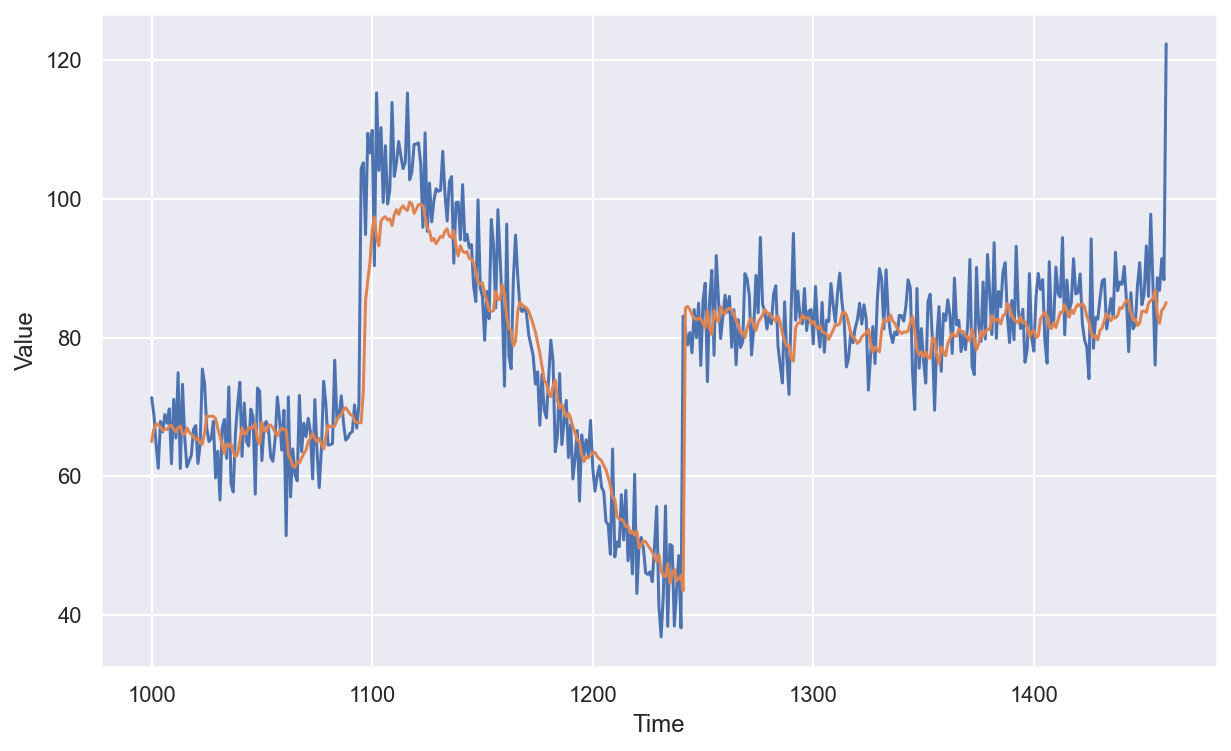

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0801616

<Figure size 432x288 with 0 Axes>

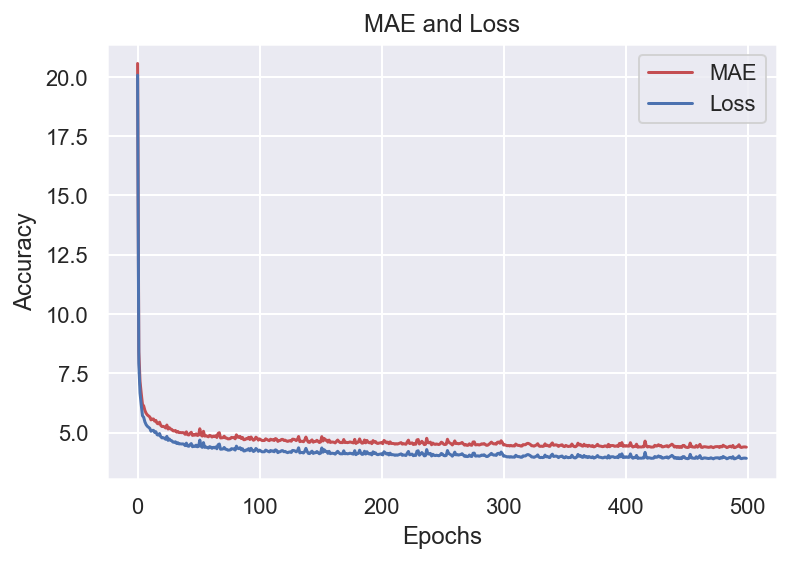

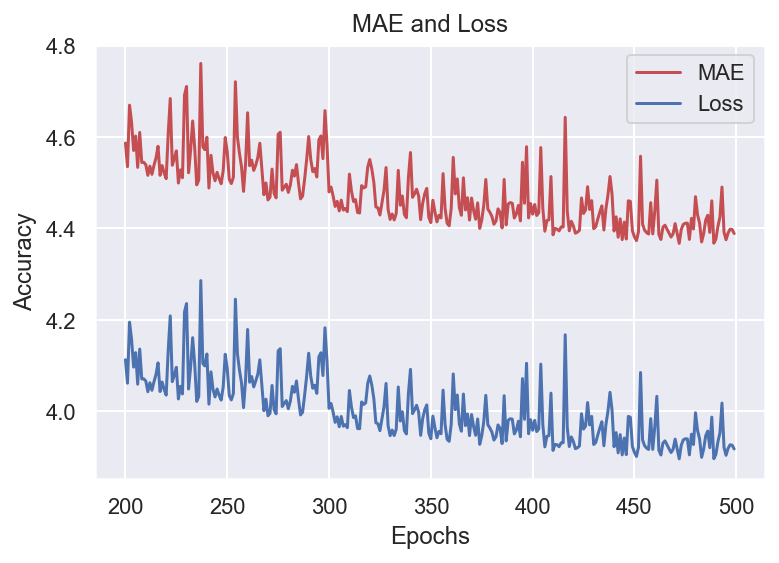

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()